In [ ]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
data = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')
data.head()

Saving ner_dataset.csv to ner_dataset.csv


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}

    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok
token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

In [ ]:
data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)
data_fillna = data.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(
['Sentence #'],as_index=False
)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

/tmp/ipython-input-1322379973.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_fillna = data.fillna(method='ffill', axis=0)


ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

In [ ]:
# Fix for pandas >= 2.0: use a LIST of columns, not a tuple
cols = ['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx']

# Rebuild data_group correctly (no need to change your previous variables)
data_group = (
    data_fillna
    .groupby('Sentence #', as_index=False)[cols]
    .agg(list)     # same as lambda x: list(x), just cleaner/faster
)


In [ ]:
# Forward-fill the modern way (creates a new var; leaves old code untouched)
data_fillna2 = data.ffill()

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]

    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )

    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)

train_tokens length: 32372 
train_tokens length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791


In [ ]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)


In [ ]:
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

In [ ]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

In [ ]:
results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (1, 104, 64)           │     2,251,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (1, 104, 128)          │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (1, 104, 64)           │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (1, 104, 17)           │         1,105 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,368,017 (9.03 MB)

 Trainable params: 2,368,017 (9.03 MB)

 Non-trainable params: 0 (0.00 B)

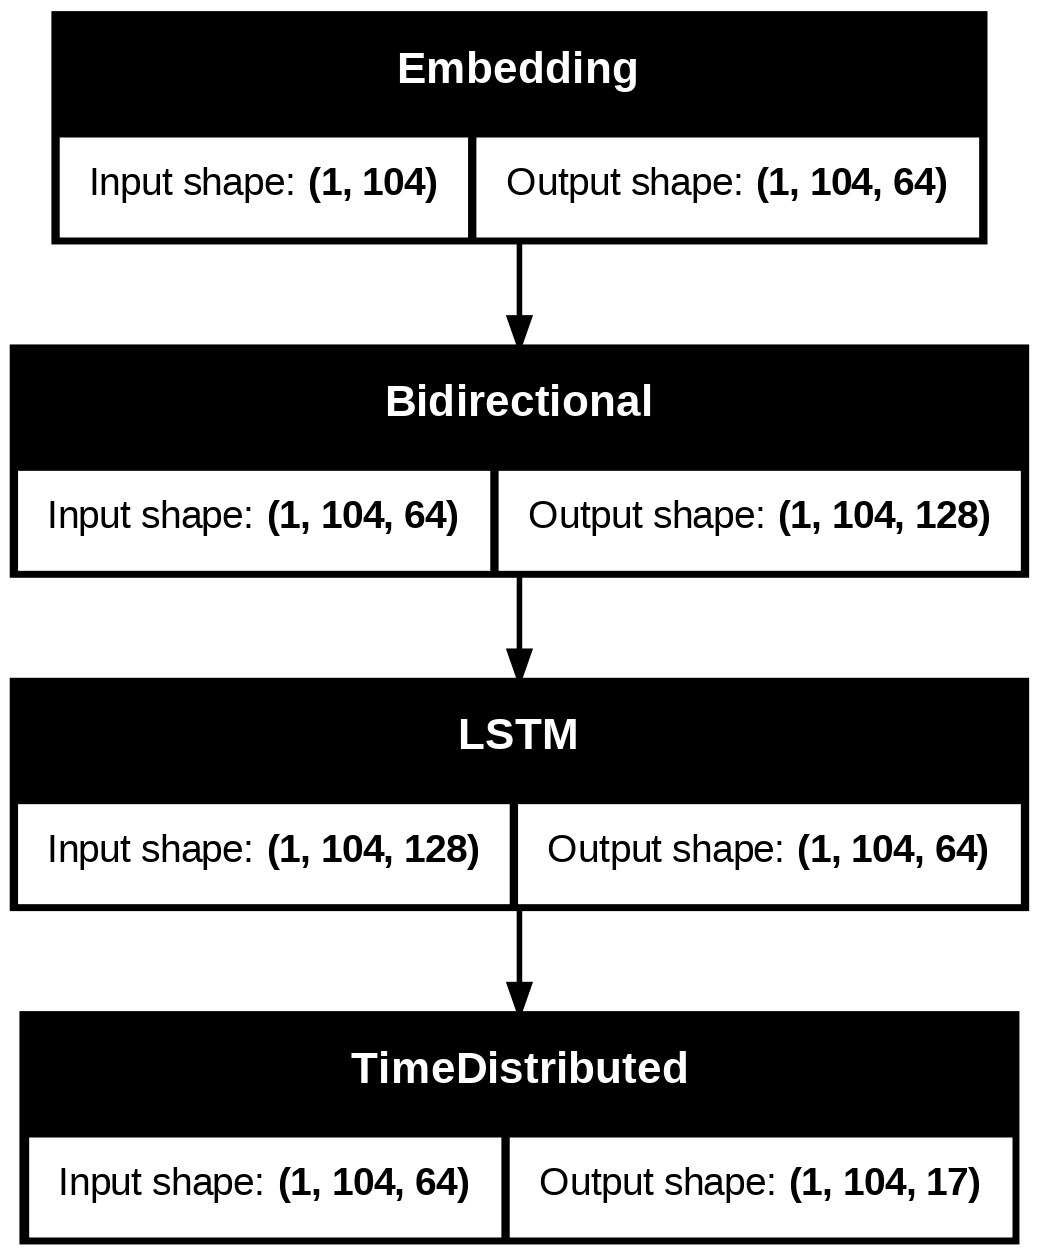

In [ ]:
# Build the model once so plot_model can visualize it
import tensorflow as tf
import numpy as np

# Infer the sequence length from your padded tokens
max_len = train_tokens.shape[1]

# Do a dummy forward pass to build the layers
_ = model_bilstm_lstm(tf.zeros((1, max_len), dtype=tf.int32), training=False)

# (Optional) check summary
model_bilstm_lstm.summary()

# Now plotting will work
from keras.utils import plot_model
plot_model(model_bilstm_lstm, show_shapes=True, expand_nested=True)


In [ ]:
results['with_add_lstm'] = train_model(train_tokens, np.array(train_tags), model_bilstm_lstm)


26/26 ━━━━━━━━━━━━━━━━━━━━ 170s 6s/step - accuracy: 0.7956 - loss: 2.5996 - val_accuracy: 0.9681 - val_loss: 0.3817
26/26 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.9676 - loss: 0.3781 - val_accuracy: 0.9681 - val_loss: 0.3172
26/26 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - accuracy: 0.9676 - loss: 0.3304 - val_accuracy: 0.9682 - val_loss: 0.2708
26/26 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.9676 - loss: 0.2935 - val_accuracy: 0.9681 - val_loss: 0.2384
26/26 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.9541 - loss: 0.3308 - val_accuracy: 0.9647 - val_loss: 0.2845
26/26 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.9567 - loss: 0.3054 - val_accuracy: 0.9681 - val_loss: 0.2169
26/26 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.9669 - loss: 0.2485 - val_accuracy: 0.9681 - val_loss: 0.2040
26/26 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.9675 - loss: 0.2379 - val_accuracy: 0.9681 - val_loss: 0.1928
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.9676 - loss: 0.224

In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
text = nlp('Hi, My name is Sanjana   \n  I am from India \n I want to work in Google')
displacy.render(text, style = 'ent', jupyter=True)